# Evaluation of off-the-shelf coreference models

In [1]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt

## Preparation

First we read our test data. 

In [ ]:
sys.path.append(r'../')

In [4]:
from quillnlp.utils import extract_referents_from_xml_tagged_strings

ModuleNotFoundError: No module named 'quillnlp'

In [5]:
DATA_DIR = Path("../../data")
COREF_TEST_DATA = DATA_DIR / "validated/pronom_coref_res/junkfood_coref_gold.tsv"

texts = []
with open(COREF_TEST_DATA) as i:
    for line in i:
        line = line.strip().split("\t")
        text = " ".join(line)
        texts.append(text)
        
data = list(extract_referents_from_xml_tagged_strings(texts))

[{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 72, 'end': 93, 'str_': 'more nutritious foods', 'id': '2'}, {'start': 102, 'end': 106, 'str_': 'they', 'id': '2'}]
[{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 60, 'end': 62, 'str_': 'it', 'id': '1'}]
[{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 60, 'end': 64, 'str_': 'they', 'id': '0'}]
[{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 66, 'str_': 'it', 'id': '1'}, {'start': 78, 'end': 83, 'str_': 'their', 'id': '2'}]
[{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 68, 'str_': 'they', 'id': '0'}]
[{'start': 0, 'end': 7, 'str_': 'Schools', 'id':

Then we load spaCy's English pipeline and add Huggingface's Neuralcoref pipe to it.

In [6]:
import spacy
import neuralcoref

nlp = spacy.load("en")
neuralcoref.add_to_pipe(nlp)

Finally, we load AllenNLP's coreference predictor.

In [7]:
from allennlp.predictors.predictor import Predictor

predictor = Predictor.from_path("https://s3-us-west-2.amazonaws.com/allennlp/models/coref-model-2018.02.05.tar.gz")

/Users/yvespeirsman/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


## Evaluation methods

In [8]:
from collections import defaultdict

def evaluate_links(predicted_links, gold_links):
    """ 
    Evaluates a set of predicted co-reference links against 
    a set of gold co-reference links. 
    """
    tp, fp, fn = 0, 0, 0
    for link in predicted_links:
        if link in gold_links:
            tp += 1
        else:
            fp += 1
    
    for link in gold_links:
        if link not in predicted_links:
            fn += 1
            
    return (tp, fp, fn)


def transform_coref_clusters_to_links(data_item):
    """
    Transforms a data item and transforms its coreference clusters
    to a list of coreference links.  
    """
    gold_clusters = defaultdict(list)
    for ref in data_item["refs"]:
        gold_clusters[ref["id"]].append((ref["start"], ref["str_"]))

    gold_links = []
    for c_id, c_words in gold_clusters.items():
        if len(c_words) > 1:     
            c_words.sort()
            antecedent = c_words[0]
            for other_word in c_words[1:]:
                gold_links.append((antecedent[0], other_word[0]))
    return gold_links


def get_coref_links_from_spacy_doc(doc):
    """
    Takes a spaCy doc on which co-reference has been performed with 
    Huggingface's Neuralcoref system, and gets the coreference links
    from this document.
    """
    predicted_links = []
    print("NeuralCoref output:", doc._.coref_clusters)
    for c in doc._.coref_clusters:
        antecedent = c[0]
        for other_word in c[1:]:
            predicted_links.append((antecedent.start_char, other_word.start_char))
    return predicted_links
            

def get_coref_links_from_allennlp(text, prediction):
    """
    Takes a text and the corresponding output of the AllenNLP 
    coreference model, and gets the coreference links from this input.
    Tokenization is performed with spaCy. This is AllenNLP's standard
    solution and is also Neuralcoref's tokenization method.
    """
    predicted_links = []
    spacy_doc = nlp(text)
    print("AllenNLP Output:", prediction["clusters"])
    for c in prediction["clusters"]:
        antecedent_token_idx = c[0][0]
        for other_word in c[1:]:
            antecedent_char_idx = spacy_doc[antecedent_token_idx].idx
            other_word_token_idx = other_word[0]
            other_word_char_idx = spacy_doc[other_word_token_idx].idx
            predicted_links.append((antecedent_char_idx, other_word_char_idx))
    
    return predicted_links
    

def evaluate_coref(data, model):
    """
    Perform a full evaluation round on our test data.
    Model is either "neuralcoref" or "allennlp".
    """
    tp, fp, fn = 0, 0, 0
    for data_item in data:
        print(data_item)
        gold_links = transform_coref_clusters_to_links(data_item)
        
        if model == "neuralcoref":
            doc = nlp(data_item["text"])
            predicted_links = get_coref_links_from_spacy_doc(doc)    
        
        elif model == "allennlp":
            prediction = predictor.predict(document=data_item["text"])
            predicted_links = get_coref_links_from_allennlp(data_item["text"], prediction)
            
        else:
            return ValueError(f"Unknown model: {model}")
                    
        print("Predicted links:", predicted_links)
        print("Gold links", gold_links)
        print("\n")

        tp_, fp_, fn_ = evaluate_links(predicted_links, gold_links)

        tp += tp_
        fp += fp_
        fn += fn_

    p = tp/(tp+fp)
    r = tp/(tp+fn)
    f = 2*p*r/(p+r) if p+r > 0 else 0

    print("Precision:", p)
    print("Recall:", r)
    print("F1 score:", f)
    return p, r, f
    

## Evaluation Neuralcoref

In [9]:
p_neuralcoref, r_neuralcoref, f_neuralcoref = evaluate_coref(data, model="neuralcoref")

{'text': 'Schools should not allow junk food to be sold on campus but should sell more nutritious foods because they have great nutritional value', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 72, 'end': 93, 'str_': 'more nutritious foods', 'id': '2'}, {'start': 102, 'end': 106, 'str_': 'they', 'id': '2'}]}
NeuralCoref output: [more nutritious foods: [more nutritious foods, they]]
Predicted links: [(72, 102)]
Gold links [(72, 102)]


{'text': 'Schools should not allow junk food to be sold on campus but it generates money for schools', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 60, 'end': 62, 'str_': 'it', 'id': '1'}]}
NeuralCoref output: [Schools: [Schools, it]]
Predicted links: [(0, 60)]
Gold links [(25, 60)]


{'text': 'Schools should not allow junk food to be sold on campus but they should have greater accessibi

NeuralCoref output: []
Predicted links: []
Gold links [(25, 64)]


{'text': 'Schools should not allow junk food to be sold on campus but I do not think that schools will totally eliminate junk food on campus because it generates much needed money for them', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 60, 'end': 61, 'str_': 'I', 'id': '2'}, {'start': 139, 'end': 141, 'str_': 'it', 'id': '1'}, {'start': 174, 'end': 178, 'str_': 'them', 'id': '0'}]}
NeuralCoref output: [schools: [schools, them]]
Predicted links: [(80, 174)]
Gold links [(0, 174), (25, 139)]


{'text': 'Schools should not allow junk food to be sold on campus because it promotes an unhealthy lifestyle.', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 66, 'str_': 'it', 'id': '1'}]}
NeuralCoref output: [Schools: [Schools, it]]
Predicted links: [(0,

NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(0, 64)]
Gold links [(25, 64)]


{'text': 'Schools should not allow junk food to be sold on campus because it is not good for health.', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 66, 'str_': 'it', 'id': '1'}]}
NeuralCoref output: []
Predicted links: []
Gold links [(25, 64)]


{'text': 'Schools should not allow junk food to be sold on campus but we cannot protect our kids from everything bad for them out there', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 60, 'end': 62, 'str_': 'we', 'id': '2'}, {'start': 111, 'end': 115, 'str_': 'them', 'id': '3'}]}
NeuralCoref output: [we: [we, our], our kids: [our kids, them]]
Predicted links: [(60, 78), (78, 111)]
Gold links []


{'text': 'Schools should not allow junk food to be sold on campus because 

NeuralCoref output: [kids: [kids, they], it: [it, it]]
Predicted links: [(60, 95), (89, 114)]
Gold links [(25, 89), (25, 114), (60, 95)]


{'text': 'Schools should not allow junk food to be sold on campus but they should teach how to incorporate small amount of these food into diet for enjoyment', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 60, 'end': 64, 'str_': 'they', 'id': '0'}, {'start': 113, 'end': 118, 'str_': 'these', 'id': '1'}]}
NeuralCoref output: [Schools: [Schools, they], junk food: [junk food, these food]]
Predicted links: [(0, 60), (25, 113)]
Gold links [(0, 60), (25, 113)]


{'text': 'Schools should not allow junk food to be sold on campus because it is bad for students health.', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 66, 'str_': 'it', 'id': '1'}]}
NeuralCoref output: []
Predicted li

NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(0, 60)]
Gold links [(0, 60)]


{'text': "Schools should not allow junk food to be sold on campus because it is bad effect to students' health", 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 66, 'str_': 'it', 'id': '1'}]}
NeuralCoref output: []
Predicted links: []
Gold links [(25, 64)]


{'text': 'Schools should not allow junk food to be sold on campus but they have to get an incentive to stop offering it', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 60, 'end': 64, 'str_': 'they', 'id': '0'}, {'start': 107, 'end': 109, 'str_': 'it', 'id': '1'}]}
NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(0, 60)]
Gold links [(0, 60), (25, 107)]


{'text': 'Schools should not allow junk food to be sold on campus but could consider selling

NeuralCoref output: []
Predicted links: []
Gold links [(25, 64)]


{'text': 'Schools should not allow junk food to be sold on campus because we all know the negative effect junk foods have on health.', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 66, 'str_': 'we', 'id': '-1'}]}
NeuralCoref output: []
Predicted links: []
Gold links []


{'text': 'Schools should not allow junk food to be sold on campus because it’s not good for the health of their students.', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 66, 'str_': 'it', 'id': '1'}, {'start': 96, 'end': 101, 'str_': 'their', 'id': '0'}]}
NeuralCoref output: [Schools: [Schools, their]]
Predicted links: [(0, 96)]
Gold links [(0, 96), (25, 64)]


{'text': 'Schools should not allow junk food to be sold on campus but ultimately it is up to the individu

NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(0, 60)]
Gold links [(0, 60)]


{'text': 'Schools should not allow junk food to be sold on campus but they should allow students to choose what they eat by bringing their own snacks if they want', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 60, 'end': 64, 'str_': 'they', 'id': '0'}, {'start': 78, 'end': 86, 'str_': 'students', 'id': '2'}, {'start': 102, 'end': 106, 'str_': 'they', 'id': '2'}, {'start': 123, 'end': 128, 'str_': 'their', 'id': '2'}, {'start': 143, 'end': 147, 'str_': 'they', 'id': '2'}]}
NeuralCoref output: [Schools: [Schools, they, they, their, they]]
Predicted links: [(0, 60), (0, 102), (0, 123), (0, 143)]
Gold links [(0, 60), (78, 102), (78, 123), (78, 143)]


{'text': 'Schools should not allow junk food to be sold on campus because it does not promote healthy eating habits and poses health risks.', 'refs': [{'start': 

Predicted links: []
Gold links [(25, 64)]


{'text': 'Schools should not allow junk food to be sold on campus but they should not express disapproval of children who bring junk food in their own lunches', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 60, 'end': 64, 'str_': 'they', 'id': '0'}, {'start': 99, 'end': 107, 'str_': 'children', 'id': '2'}, {'start': 131, 'end': 136, 'str_': 'their', 'id': '2'}]}
NeuralCoref output: [Schools: [Schools, they, their]]
Predicted links: [(0, 60), (0, 131)]
Gold links [(0, 60), (99, 131)]


{'text': 'Schools should not allow junk food to be sold on campus because it contributes to the development of diabetes.', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 66, 'str_': 'it', 'id': '1'}]}
NeuralCoref output: []
Predicted links: []
Gold links [(25, 64)]


{'text': 'Schools 

NeuralCoref output: []
Predicted links: []
Gold links [(25, 64)]


{'text': 'Schools should not allow junk food to be sold on campus but they could sell a variety of healthy snacks', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 60, 'end': 64, 'str_': 'they', 'id': '0'}]}
NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(0, 60)]
Gold links [(0, 60)]


{'text': 'Schools should not allow junk food to be sold on campus but they should stock the cafeteria and machines with healthier snack options to provide food for the kids and generate income for the school', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 60, 'end': 64, 'str_': 'they', 'id': '0'}]}
NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(0, 60)]
Gold links [(0, 60)]


{'text': 'Schools should not allow junk food to be sold on camp

Gold links [(25, 64)]


{'text': 'Schools should not allow junk food to be sold on campus because they can be unhealthy.', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 68, 'str_': 'they', 'id': '1'}]}
NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(0, 64)]
Gold links [(25, 64)]


{'text': 'Schools should not allow junk food to be sold on campus because it increases risks of diabetes.', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 66, 'str_': 'it', 'id': '1'}]}
NeuralCoref output: []
Predicted links: []
Gold links [(25, 64)]


{'text': 'Schools should not allow junk food to be sold on campus because it is unhealthy and it is causing obesity and diabetes.', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'s

## Evaluation AllenNLP

In [10]:
p_allennlp, r_allennlp, f_allennlp = evaluate_coref(data, model="allennlp")

Encountered the antecedent_indices key in the model's return dictionary which couldn't be split by the batch size. Key will be ignored.


{'text': 'Schools should not allow junk food to be sold on campus but should sell more nutritious foods because they have great nutritional value', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 72, 'end': 93, 'str_': 'more nutritious foods', 'id': '2'}, {'start': 102, 'end': 106, 'str_': 'they', 'id': '2'}]}
AllenNLP Output: [[[14, 16], [18, 18]]]
Predicted links: [(72, 102)]
Gold links [(72, 102)]


{'text': 'Schools should not allow junk food to be sold on campus but it generates money for schools', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 60, 'end': 62, 'str_': 'it', 'id': '1'}]}
AllenNLP Output: []
Predicted links: []
Gold links [(25, 60)]


{'text': 'Schools should not allow junk food to be sold on campus but they should have greater accessibility to nutrient dense foods', 'refs': [{'start': 0, 'end': 7, 'str

AllenNLP Output: [[[0, 0], [12, 12]], [[4, 5], [23, 23]]]
Predicted links: [(0, 60), (25, 127)]
Gold links [(0, 60), (101, 127)]


{'text': 'Schools should not allow junk food to be sold on campus but It could potentially be sold in moderation and let kids make their own choices', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 60, 'end': 62, 'str_': 'It', 'id': '1'}, {'start': 111, 'end': 115, 'str_': 'kids', 'id': '2'}, {'start': 121, 'end': 126, 'str_': 'their', 'id': '2'}]}
AllenNLP Output: []
Predicted links: []
Gold links [(25, 60), (111, 121)]


{'text': 'Schools should not allow junk food to be sold on campus because it leads to higher numbers of type 2 diabetes among kids.', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 66, 'str_': 'it', 'id': '1'}]}
AllenNLP Output: [[[4, 5], [12, 12]]]
Predicted lin

AllenNLP Output: [[[15, 17], [21, 21]]]
Predicted links: [(73, 100)]
Gold links [(25, 60), (73, 100)]


{'text': 'Schools should not allow junk food to be sold on campus but students should be allowed to bring junk food if the parents provide it', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 129, 'end': 131, 'str_': 'it', 'id': '1'}]}
AllenNLP Output: [[[18, 19], [24, 24]]]
Predicted links: [(96, 129)]
Gold links [(25, 129)]


{'text': 'Schools should not allow junk food to be sold on campus because they do not have any nutrition value.', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 68, 'str_': 'they', 'id': '1'}]}
AllenNLP Output: [[[0, 0], [12, 12]]]
Predicted links: [(0, 64)]
Gold links [(25, 64)]


{'text': 'Schools should not allow junk food to be sold on campus because it is not good for health.', 'r

AllenNLP Output: [[[12, 12], [21, 21], [26, 26]], [[4, 5], [31, 31]]]
Predicted links: [(64, 118), (64, 141), (25, 161)]
Gold links [(0, 64), (25, 128), (25, 161), (103, 118), (103, 141)]


{'text': 'Schools should not allow junk food to be sold on campus because it promotes obesity and type 2 diabetes.', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 66, 'str_': 'it', 'id': '1'}]}
AllenNLP Output: [[[4, 5], [12, 12]]]
Predicted links: [(25, 64)]
Gold links [(25, 64)]


{'text': 'Schools should not allow junk food to be sold on campus but kids should be able to bring it if they choose to eat it', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 60, 'end': 64, 'str_': 'kids', 'id': '2'}, {'start': 89, 'end': 91, 'str_': 'it', 'id': '1'}, {'start': 95, 'end': 99, 'str_': 'they', 'id': '2'}, {'start': 114, 'end': 1

AllenNLP Output: []
Predicted links: []
Gold links [(25, 64)]


{'text': 'Schools should not allow junk food to be sold on campus but they still do because it is used as a tool to raise money', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 60, 'end': 64, 'str_': 'they', 'id': '0'}, {'start': 82, 'end': 84, 'str_': 'it', 'id': '1'}]}
AllenNLP Output: [[[4, 5], [16, 16]]]
Predicted links: [(25, 82)]
Gold links [(0, 60), (25, 82)]


{'text': 'Schools should not allow junk food to be sold on campus but they did not take step to stop selling', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 60, 'end': 64, 'str_': 'they', 'id': '0'}]}
AllenNLP Output: []
Predicted links: []
Gold links [(0, 60)]


{'text': 'Schools should not allow junk food to be sold on campus because it promotes bad eating habits, increasing the odds of heal

AllenNLP Output: [[[4, 5], [13, 13], [20, 20]]]
Predicted links: [(25, 63), (25, 91)]
Gold links [(25, 63), (25, 91)]


{'text': 'Schools should not allow junk food to be sold on campus but if it is brought from home than it is ok', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 63, 'end': 65, 'str_': 'it', 'id': '1'}, {'start': 92, 'end': 94, 'str_': 'it', 'id': '1'}]}
AllenNLP Output: [[[4, 5], [13, 13], [19, 19]]]
Predicted links: [(25, 63), (25, 92)]
Gold links [(25, 63), (25, 92)]


{'text': 'Schools should not allow junk food to be sold on campus because it leads to unhealthy habits for kids from a young age.', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 66, 'str_': 'it', 'id': '1'}]}
AllenNLP Output: [[[4, 5], [12, 12]]]
Predicted links: [(25, 64)]
Gold links [(25, 64)]


{'text': 'Schools should not

AllenNLP Output: [[[4, 5], [21, 21]]]
Predicted links: [(25, 104)]
Gold links [(25, 65), (25, 104)]


{'text': 'Schools should not allow junk food to be sold on campus but it is also our responsibility as parents to teach healthy eating habits', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 60, 'end': 62, 'str_': 'it', 'id': '-1'}]}
AllenNLP Output: []
Predicted links: []
Gold links []


{'text': 'Schools should not allow junk food to be sold on campus but I understand the argument that students should be able to chose what they eat', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 60, 'end': 61, 'str_': 'I', 'id': '-1'}, {'start': 91, 'end': 99, 'str_': 'students', 'id': '2'}, {'start': 129, 'end': 133, 'str_': 'they', 'id': '2'}]}
AllenNLP Output: [[[17, 17], [24, 24]]]
Predicted links: [(91, 129)]
Gold links [(91, 129

AllenNLP Output: [[[0, 0], [12, 12]]]
Predicted links: [(0, 60)]
Gold links [(0, 60)]


{'text': 'Schools should not allow junk food to be sold on campus because it is known to cause negative effect on your health.', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 66, 'str_': 'it', 'id': '1'}]}
AllenNLP Output: []
Predicted links: []
Gold links [(25, 64)]


{'text': 'Schools should not allow junk food to be sold on campus because it is not nutritious and causes diabetes.', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 66, 'str_': 'it', 'id': '1'}]}
AllenNLP Output: [[[4, 5], [12, 12]]]
Predicted links: [(25, 64)]
Gold links [(25, 64)]


{'text': 'Schools should not allow junk food to be sold on campus but they should stack the snack machines with just a few junk food and 98% of the snacks should be 

AllenNLP Output: []
Predicted links: []
Gold links [(0, 60)]


{'text': 'Schools should not allow junk food to be sold on campus because they are unhealthy and can have long term effects.', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 68, 'str_': 'they', 'id': '1'}]}
AllenNLP Output: []
Predicted links: []
Gold links [(25, 64)]


{'text': 'Schools should not allow junk food to be sold on campus but they could still sell healthy snacks', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 60, 'end': 64, 'str_': 'they', 'id': '0'}]}
AllenNLP Output: [[[0, 0], [12, 12]]]
Predicted links: [(0, 60)]
Gold links [(0, 60)]


{'text': 'Schools should not allow junk food to be sold on campus because it is not good for the students health.', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end':

AllenNLP Output: [[[0, 0], [12, 12]]]
Predicted links: [(0, 60)]
Gold links [(0, 60)]


{'text': 'Schools should not allow junk food to be sold on campus because it has proven to be unhealthy and is not benefiting schools or school related tasks in any way.', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 66, 'str_': 'it', 'id': '1'}, {'start': 151, 'end': 154, 'str_': 'any', 'id': '?'}]}
AllenNLP Output: [[[4, 5], [12, 12]]]
Predicted links: [(25, 64)]
Gold links [(25, 64)]


{'text': 'Schools should not allow junk food to be sold on campus because it encourages unhealthy behavior.', 'refs': [{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 66, 'str_': 'it', 'id': '1'}]}
AllenNLP Output: [[[4, 5], [12, 12]]]
Predicted links: [(25, 64)]
Gold links [(25, 64)]


{'text': 'Schools should not allow junk food to be

## Comparison

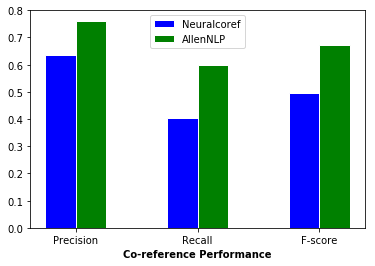

In [11]:
import numpy as np
import matplotlib.pyplot as plt
 
barWidth = 0.25
 
bars1 = [p_neuralcoref, r_neuralcoref, f_neuralcoref]
bars2 = [p_allennlp, r_allennlp, f_allennlp]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='blue', width=barWidth, edgecolor='white', label='Neuralcoref')
plt.bar(r2, bars2, color='green', width=barWidth, edgecolor='white', label='AllenNLP')
 
# Add xticks on the middle of the group bars
plt.xlabel('Co-reference Performance', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], ['Precision', 'Recall', 'F-score'])
 
# Create legend & Show graphic
plt.legend()
plt.show()
